#### Importando las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from prophet import Prophet

c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


##### Función `analiza_serie` (pipeline que realiza un análisis univariante,
##### búsqueda de parámetros para 3 modelos ARIMA y ajuste de gráfica con un modelo Prophet)

In [2]:
def analiza_serie(ts: pd.Series, label: str, max_p: int = 2, max_q: int = 2):
    """
    Ejecuta análisis univariante completo sobre ts:
      a) Imprime inicio, fin y frecuencia
      b) Grafica la serie
      c) Descompone en tendencia/estacional/residual
      d) Estabiliza varianza via log si hace falta
      e) Test ADF y diferencia para estacionarizar media
      f) Muestra FAC/FACP del resultado
      g) Busca ARIMA(p,d,q) óptimo por AIC
      h) Ajusta y grafica un modelo Prophet
    """
    # a) inicio, fin, freq
    print(f"\n--- {label} ---")
    print("Inicio:", ts.index.min())
    print("Fin   :", ts.index.max())
    print("Freq  :", ts.index.freq)
    
    # b) serie original
    plt.figure(figsize=(10,3))
    plt.plot(ts, label='Nivel')
    plt.title(f"{label} (serie original)")
    plt.xlabel("Fecha"); plt.ylabel("Volumen")
    plt.tight_layout(); plt.show()
    
    # c) descomposición aditiva
    dec = seasonal_decompose(ts, model='additive')
    dec.plot()  
    plt.suptitle(f"Descomposición — {label}", y=1.02)
    plt.tight_layout(); plt.show()
    
    # d) estabilizar varianza si varianza cambió >20%
    var_early = ts.iloc[:36].var()
    var_late  = ts.iloc[-36:].var()
    if abs(var_late - var_early) / var_early > 0.2:
        ts_t = np.log(ts)
        print("→ Aplicación de logaritmo para estabilizar varianza.")
    else:
        ts_t = ts.copy()
        print("→ No requiere transformación de varianza.")
    plt.figure(figsize=(10,3))
    plt.plot(ts_t); plt.title(f"{label} (post-transform)"); plt.show()
    
    # e) test ADF + diferenciación si p>0.05
    plot_acf(ts_t.dropna(), lags=36); plt.title("FAC"); plt.show()
    pval = adfuller(ts_t.dropna())[1]
    if pval > 0.05:
        print(f"ADF p={pval:.3f} > 0.05 → no estacionaria en media. Diferenciar.")
        ts_s = ts_t.diff().dropna()
    else:
        print(f"ADF p={pval:.3f} ≤ 0.05 → estacionaria en media.")
        ts_s = ts_t.copy()
    plt.figure(figsize=(10,3))
    plt.plot(ts_s); plt.title(f"{label} (estac. media)"); plt.show()
    
    # f) FAC/FACP de la serie estacionaria en media
    plot_acf(ts_s, lags=36); plt.title("FAC (estac.)"); plt.show()
    plot_pacf(ts_s, lags=36); plt.title("FACP (estac.)"); plt.show()
    
    # g) búsqueda de ARIMA(p,d,q)
    print("\nBuscando mejor ARIMA(p,d,q) por AIC…")
    ts_arima = ts_t.dropna()
    resultados = []
    for p in range(max_p+1):
        for dval in [0, 1]:
            for q in range(max_q+1):
                # no tratar combinaciones imposibles
                if len(ts_arima) < (p + dval + q + 2):
                    continue
                try:
                    modelo = SARIMAX(
                        ts_arima,
                        order=(p, dval, q),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    res = modelo.fit(disp=False)
                    resultados.append((p, dval, q, res.aic))
                except Exception as e:
                    print(f"  → SARIMAX({p},{dval},{q}) falló: {e.__class__.__name__}")
                    continue

    if not resultados:
        print("No se pudo ajustar ningún ARIMA/SARIMAX en el rango dado.")
    else:
        resultados.sort(key=lambda x: x[3])
        top3 = resultados[:3]
        print("Top 3 SARIMAX(p,d,q) por AIC:", top3)
        p_best, d_best, q_best, aic_best = top3[0]
        mejor = SARIMAX(
            ts_arima,
            order=(p_best, d_best, q_best),
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        print(f"Mejor SARIMAX({p_best},{d_best},{q_best}) — AIC={mejor.aic:.1f}")

    
    # h) Prophet
    dfp = ts_t.reset_index()

    dfp.columns = ['ds', 'y']

    dfp = dfp.dropna(subset=['y'])

    m = Prophet(yearly_seasonality=True, weekly_seasonality=False)
    m.fit(dfp)
    fut = m.make_future_dataframe(periods=12, freq='MS')
    pred = m.predict(fut)

    fig = m.plot(pred)
    fig.suptitle(f"Prophet — {label}", y=1.02)
    plt.tight_layout()
    plt.show

#### Carga de los datos en forma CSV después de la limpieza

In [3]:
df_consumo = pd.read_csv('./df_consumo.csv', index_col='Fecha', parse_dates=True)
df_importacion = pd.read_csv('./df_importacion.csv', index_col='Fecha', parse_dates=True)

#### Generación del análisis univariante, 3 modelos de ARIMA con parámetros ajustados y modelo Prophet
> Nota: Únicamente realizado para Gasolina Regular (Consumo) para esta entrega.



--- Gasolina regular (Consumo) ---
Inicio: 2000-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


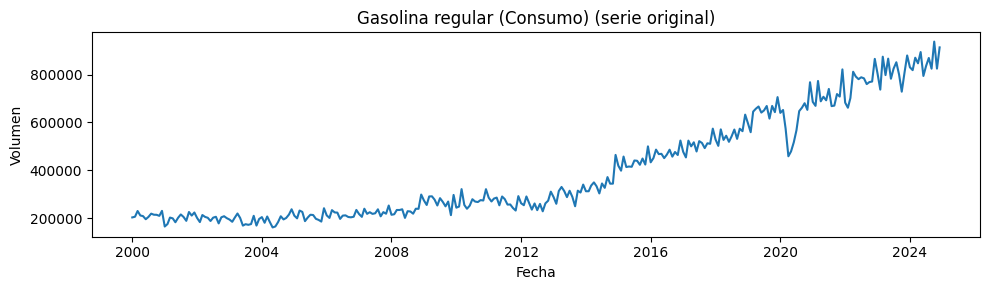

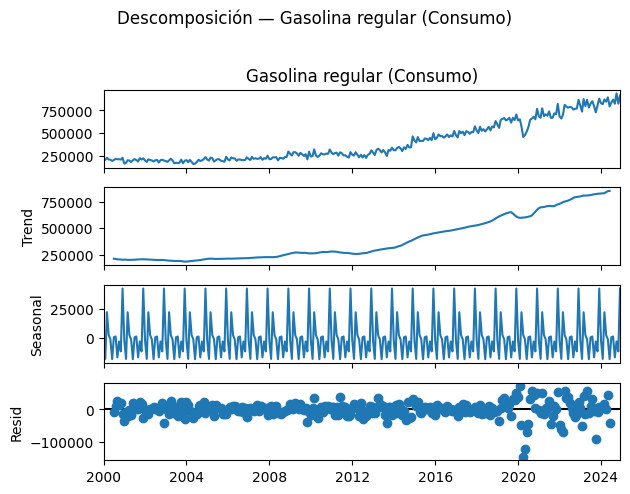

→ Aplicación de logaritmo para estabilizar varianza.


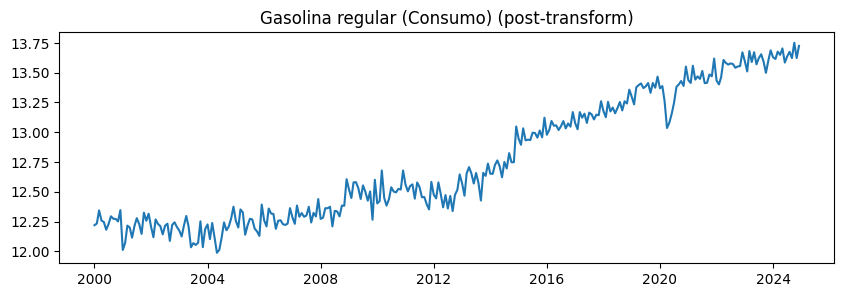

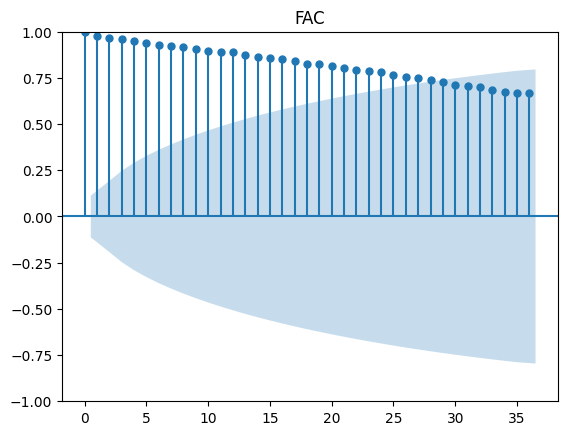

ADF p=0.992 > 0.05 → no estacionaria en media. Diferenciar.


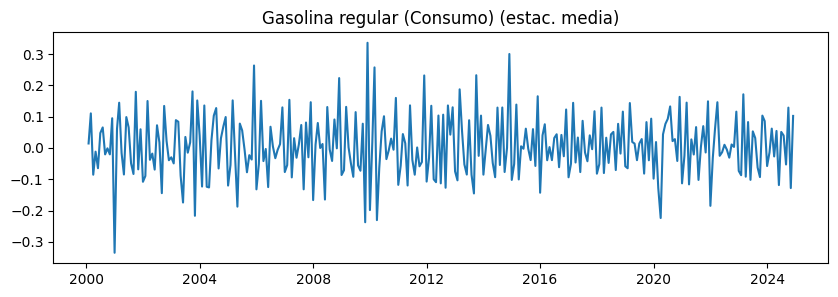

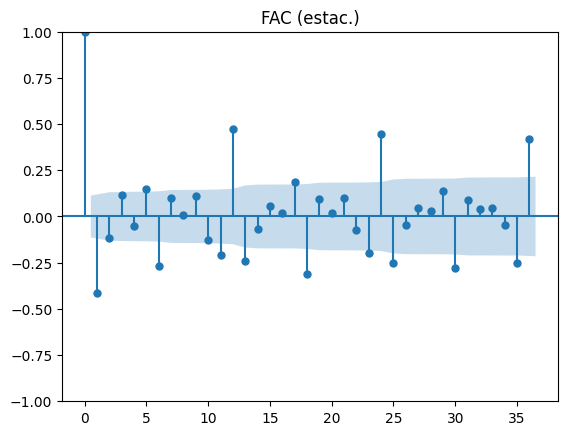

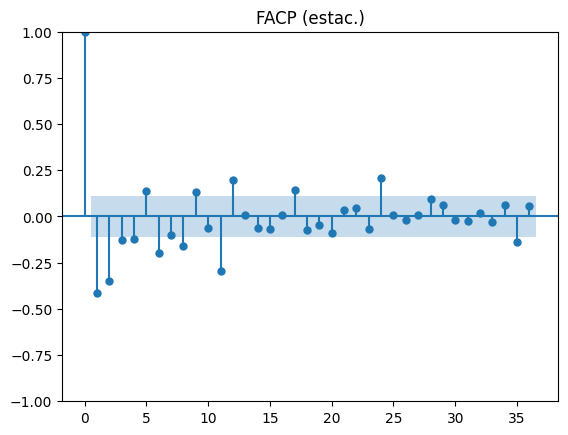


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(1, 0, 1, np.float64(-627.5753964173856)), (1, 0, 2, np.float64(-623.5329774567584)), (2, 0, 2, np.float64(-622.7592073796269))]
Mejor SARIMAX(1,0,1) — AIC=-627.6


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
13:11:09 - cmdstanpy - INFO - Chain [1] start processing
13:11:09 - cmdstanpy - INFO - Chain [1] done processing


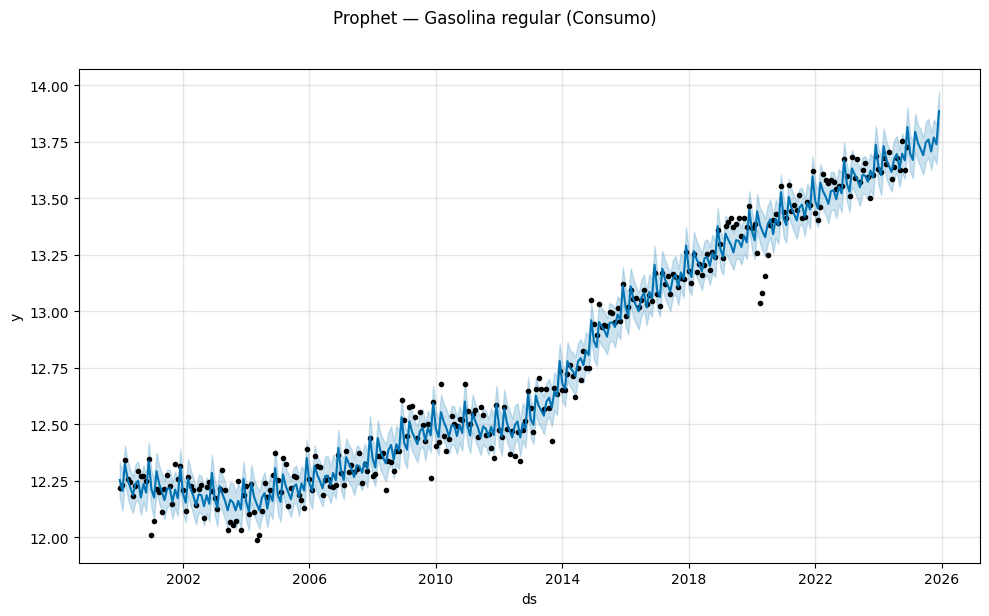

In [4]:
for col in ['Gasolina regular']:
    serie = df_consumo[col].copy()
    serie.name = f"{col} (Consumo)"
    analiza_serie(serie, serie.name)

## Discusión - Gasolina Regular (Consumo)

<small>

### 1. Serie original
  
- **Tendencia clara y creciente**: desde unos 200 000 barriles en 2000 hasta cerca de 900 000 en 2024.  
- **Variaciones estacionales evidentes**: en cada año se repiten picos y valles (meses de mayor y menor consumo).  
- **Anomalías**: fuerte caída alrededor de 2020, coincidente con los efectos de la pandemia.  

---

### 2. Descomposición aditiva

- **Tendencia (Trend)**: refuerza el crecimiento suave hasta 2014 y luego un empuje más pronunciado hasta 2024.  
- **Estacionalidad (Seasonal)**: patrón anual de amplitud casi constante de ± 25 000 barriles, con picos típicos en ciertos meses (ver gráfico).  
- **Residuales (Resid)**: distribuidos alrededor de cero con dispersión razonablemente homogénea, salvo el “outlier” pandémico.  

---

### 3. Serie tras log-transform

- La transformación logarítmica **comprime** el rango de valores y deja las oscilaciones con **amplitud más constante** a lo largo de todo el periodo.  
- Facilita el modelado si hubiera heterocedasticidad (varianza creciente con el nivel).  

---

### 4. Función de autocorrelación (FAC) sobre la serie transformada

- La **FAC decae muy lentamente** (mantiene valores altos aún en lags > 20), lo que confirma **no-estacionariedad en media**.  
- No hay corte brusco a lag q pequeño, más bien un decaimiento gradual típico de un componente AR(p).  

---

### 5. Serie diferenciada para estacionarizar la media

- Tras diferenciar una vez (d=1), la nueva serie fluctúa alrededor de cero con amplitud bastante constante → **aparentemente estacionaria en media**.  

---

### 6. FAC de la serie estacionaria

- Ahora vemos **picos secundarios** en lags 12, 24 y 36, que indican aún **correlación estacional anual**.  
- Para un ARIMA puro hemos ignorado esta estacionalidad, pero esos picos sugieren que un SARIMA(…,12) podría afinar aún más el ajuste.  

---

### 7. Modelos SARIMAX candidatos

* **Top 3 por AIC**:

  1. SARIMAX(1, 0, 1) AIC = –627.58
  2. SARIMAX(1, 0, 2) AIC = –623.53
  3. SARIMAX(2, 0, 2) AIC = –622.76
* El **mejor** fue **(1,0,1)**, lo que concuerda con la lenta decaída de la FAC y un componente MA(1) que captura la suavización de errores.

---

### 8. Pronóstico con Prophet

* La línea azul (“trend”) sigue muy de cerca la trayectoria de la serie log‐transformada, capturando correctamente tanto el crecimiento suave (2000–2008) como el empuje más pronunciado post‐2014. 
  - **Estacionalidad anual**: los “picos” regulares en la banda de incertidumbre (línea azul más clara) coinciden con los patrones estacionales vistos en la descomposición. Prophet modela explícitamente esta estacionalidad y la proyecta hacia el futuro.
  - **Intervalo de confianza**: la banda *light-blue* alrededor de la predicción aumenta ligeramente al proyectarse más allá de los datos, lo cual refleja la mayor incertidumbre a largo plazo. - - **Respuestas a outliers**: tras la caída de 2020, Prophet suaviza la recuperación; no sigue exactamente el valor pandémico atípico, lo cual puede ser deseable para no sobreajustar eventos excepcionales. 
  - **Comparación con SARIMAX**: - *Ventaja de Prophet*: integración automática de estacionalidad y tendencia no lineal, sin tener que especificar manualmente (p,d,q) ni componentes SAR. - *Ventaja de SARIMAX(1,0,1)*: menor AIC y potencialmente intervalos más cerrados en el corto plazo, pero requiere tuning manual y no modela cambios de tendencia no lineal automáticos.

---

**Conclusión para Gasolina Regular (Consumo):**

1. La serie es **no estacionaria** en media y varianza → requiere log-transform y diferenciación (d=1).
2. Un **SARIMAX(1,0,1)** ofrece el mejor equilibrio (AIC más bajo) entre parsimonia y ajuste.
3. La **estacionalidad anual** permanece tras diferenciar, por lo que un SARIMA con componente estacional podría pulir el modelo.
4. **Prophet** resultó competitivo y muy fácil de ajustar, capturando tanto tendencia como estacionalidad, pero con un intervalo de pronóstico más conservador.

</small>


--- Gasolina superior (Consumo) ---
Inicio: 2000-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


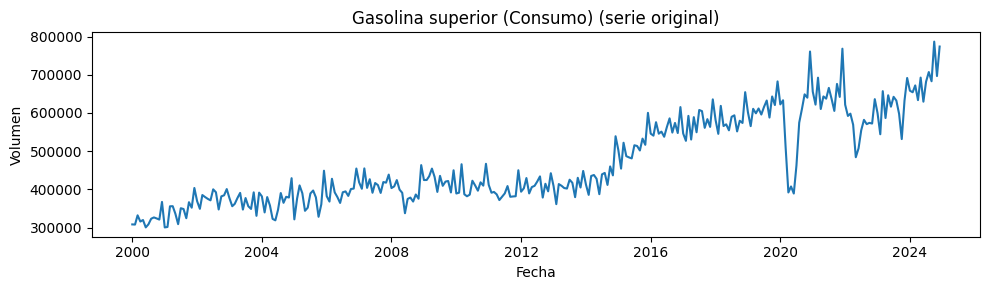

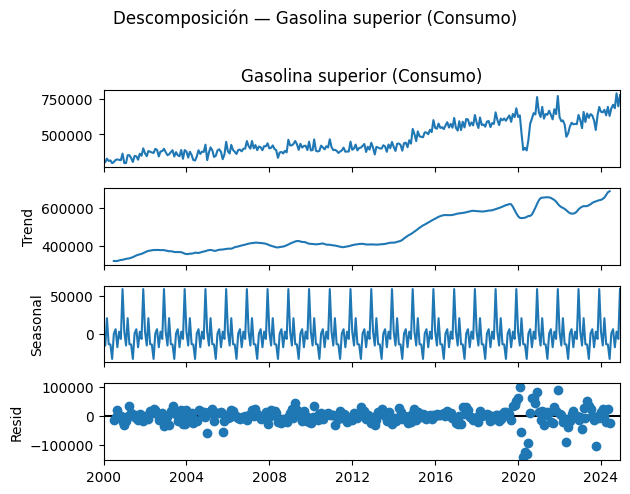

→ Aplicación de logaritmo para estabilizar varianza.


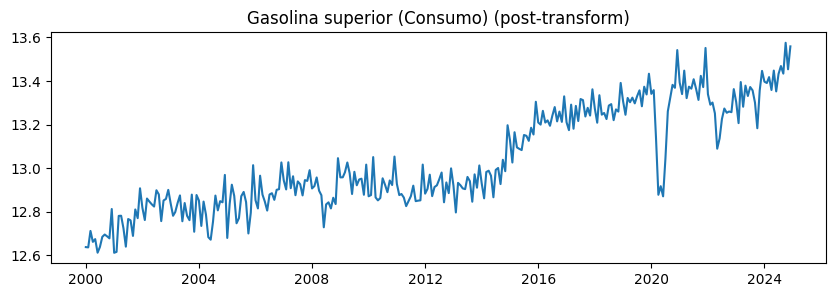

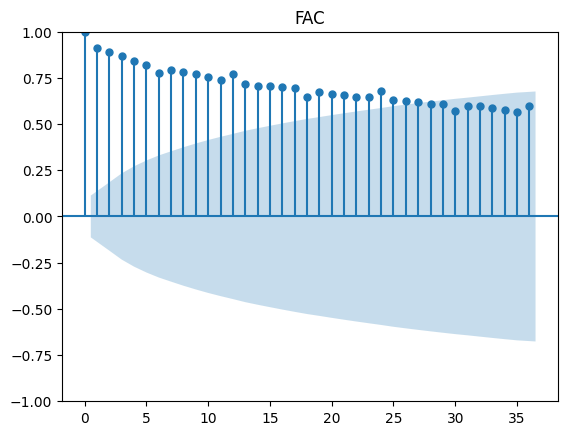

ADF p=0.860 > 0.05 → no estacionaria en media. Diferenciar.


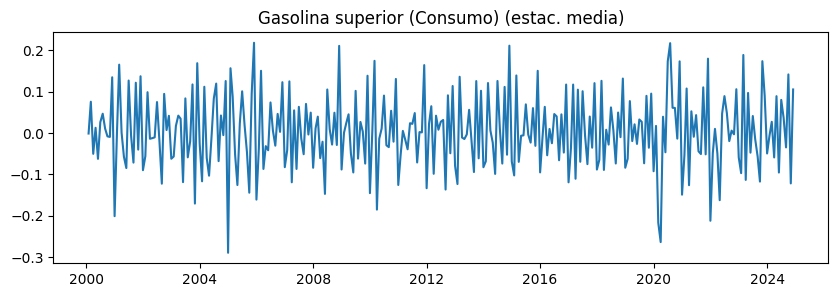

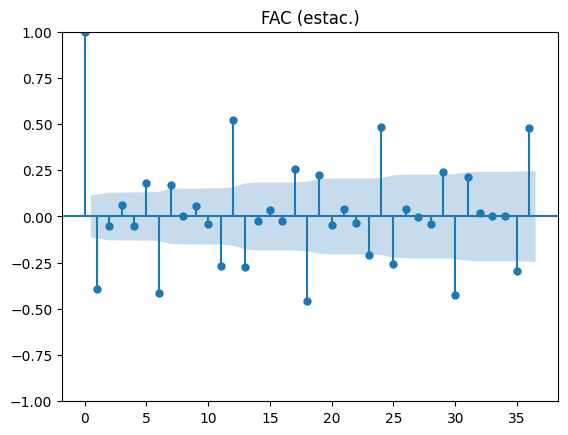

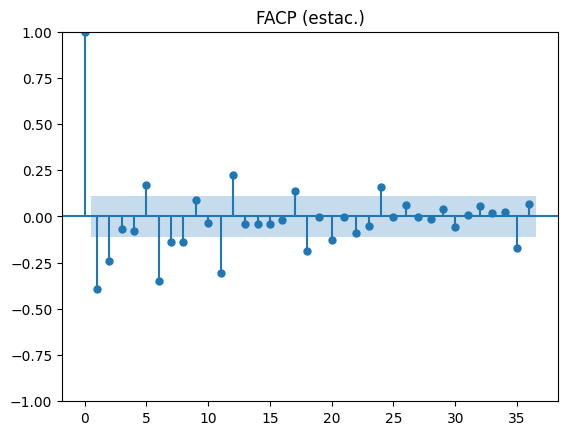


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(2, 0, 1, np.float64(-661.9771994666837)), (1, 0, 1, np.float64(-660.4282563988493)), (2, 1, 1, np.float64(-658.3616344372217))]
Mejor SARIMAX(2,0,1) — AIC=-662.0


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing


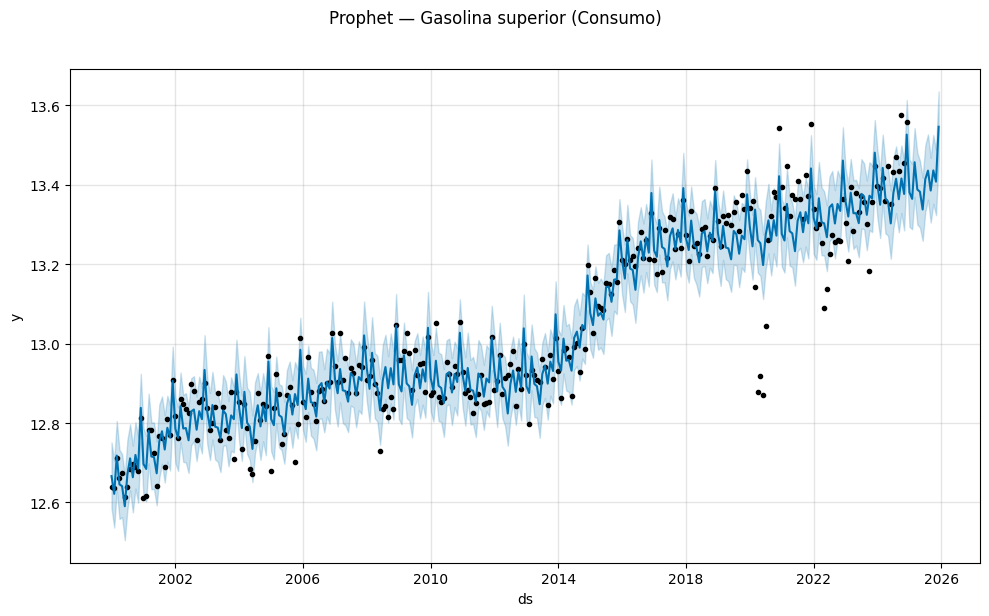

In [5]:
for col in ['Gasolina superior']:
    serie = df_consumo[col].copy()
    serie.name = f"{col} (Consumo)"
    analiza_serie(serie, serie.name)

## Discusión - Gasolina Superior (Consumo)

<small>

### 1. Serie original

- **Tendencia al alza**: va de ≈300 000 barriles (2000) a ≈800 000 barriles (2024).  
- **Estacionalidad marcada**: cada año se repiten picos y valles de casi ±50 000 barriles, más pronunciados que en gasolina regular.  
- **Quiebre pandémico**: caída brusca en 2020, seguida de recuperación rápida pero más volátil.  

---

### 2. Descomposición aditiva

- **Trend**: suave crecimiento hasta ~2014, luego un repunte más rápido hasta 2024.  
- **Seasonal**: ciclo anual de amplitud creciente (~±50 000), con picos consistentes en meses de alta demanda.  
- **Residuals**: dispersión homogénea excepto el gran outlier de 2020 (ruido pandémico).  

---

### 3. Serie tras log-transform

- El **logaritmo** comprime las oscilaciones en un rango 12.6–13.6, dejando amplitudes más constantes.  
- Facilita la modelización al **controlar heterocedasticidad** (menor varianza en los extremos).  

---

### 4. Función de autocorrelación (FAC) de la serie transformada

- La **FAC decae gradualmente**, manteniendo valores ≈0.6 incluso a lags>30: claro indicio de **no-estacionariedad en media**.  
- No hay corte súbito en un lag pequeño, típico de procesos AR(p).  

---

### 5. Serie diferenciada (estac. media)

- Al diferenciar una vez, los **niveles oscilan** alrededor de cero con amplitud estable y sin tendencia marcada → **aparente estacionariedad en media**.  

---

### 6. FAC de la serie estacionaria

- Aparecen **picos en lags 12, 24, 36** (~0.5), reflejando la **persistencia de la estacionalidad anual** aun tras diferenciar.  
- Para un ARIMA puro ignoramos este componente, pero su presencia sugiere un SARIMA con periodo 12.  

---

### 7. Modelos SARIMAX candidatos

> **Top 3 SARIMAX(p,d,q) por AIC**
>
> 1. (2, 0, 1) — AIC = –661.98
> 2. (1, 0, 1) — AIC = –660.43
> 3. (2, 1, 1) — AIC = –658.36
>
> **Mejor:** SARIMAX(2,0,1)
>
> * El **p=2** y **q=1** encajan con la lenta decaída de la FAC (componente AR2) y el pico en lag 1 (componente MA1).
> * **d=0** confirma que, tras la log-transform, la serie es suficiente estable en media sin diferenciar.



---

### 8. Pronóstico con Prophet
  
- **Tendencia no lineal**: Prophet capta el lento crecimiento inicial y el brusco cambio post-2014.  
- **Estacionalidad anual**: claramente modelada en la banda de incertidumbre.  
- **Manejo de outliers**: la caída de 2020 queda suavizada en la predicción, evitando sobreajuste a ese shock puntual.  

---

#### Conclusión para Gasolina Superior (Consumo)

* La serie tiene **tendencia creciente** y **fuerte estacionalidad anual** (±50 000).
* Tras log-transform no es necesaria diferenciación para la media (d=0).
* El **SARIMAX(2,0,1)** resulta óptimo por AIC, capturando dependencia autoregresiva de segundo orden y un término MA(1).
* **Prophet** ofrece un enfoque alternativo: modela µ no lineal y la estacionalidad sin tuning manual, ideal para escenarios con cambios de tendencia.

</small>



--- Diesel (Consumo) ---
Inicio: 2000-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


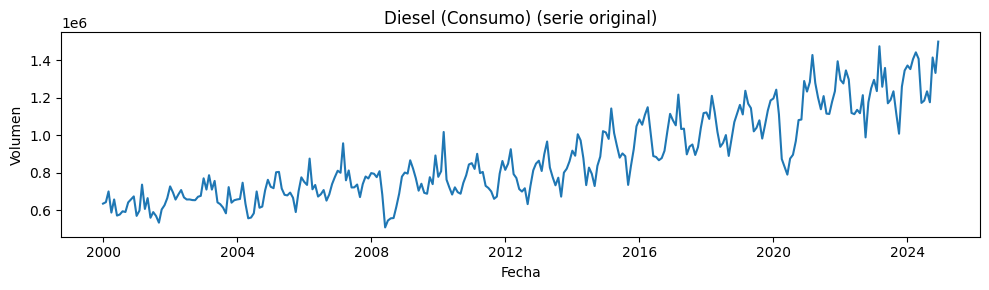

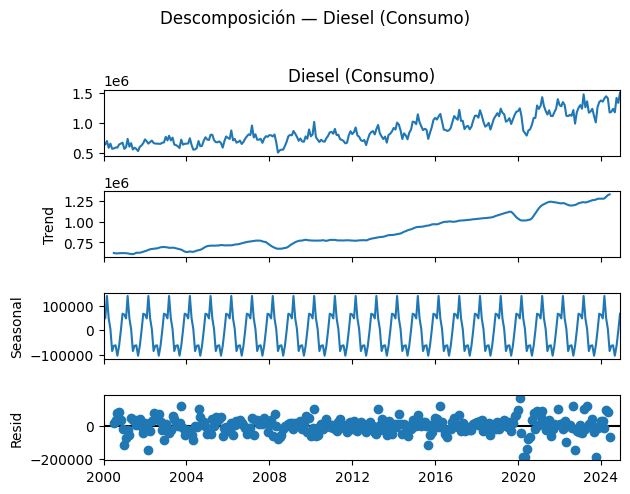

→ Aplicación de logaritmo para estabilizar varianza.


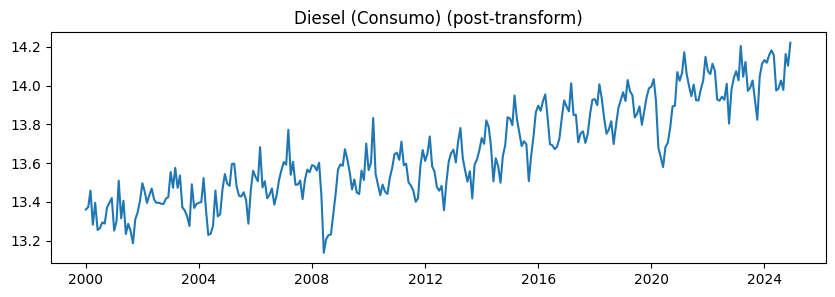

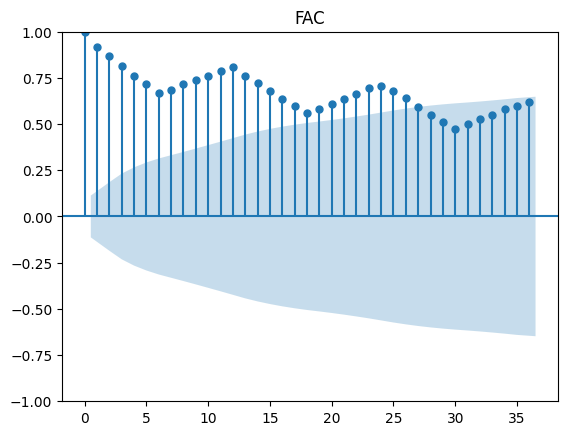

ADF p=0.939 > 0.05 → no estacionaria en media. Diferenciar.


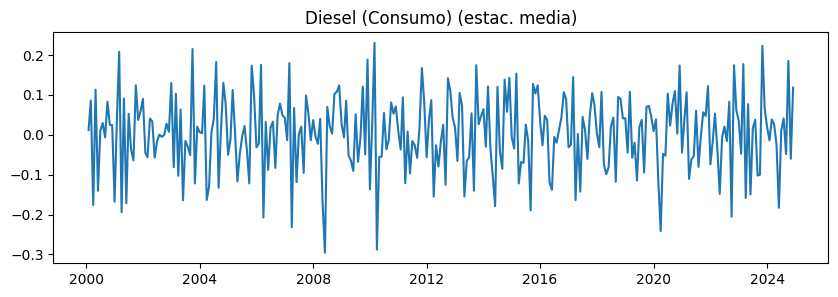

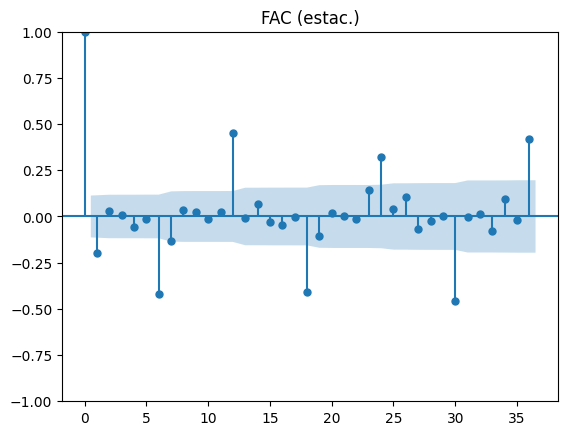

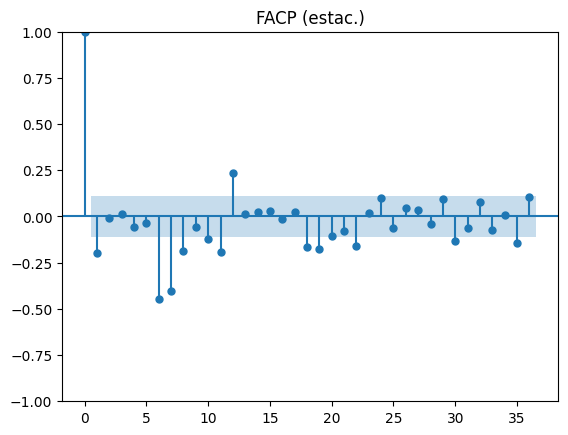


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(2, 1, 2, np.float64(-584.1421659031682)), (1, 1, 0, np.float64(-565.5563700648443)), (2, 0, 0, np.float64(-563.8881831029119))]
Mejor SARIMAX(2,1,2) — AIC=-584.1


13:11:16 - cmdstanpy - INFO - Chain [1] start processing
13:11:16 - cmdstanpy - INFO - Chain [1] done processing


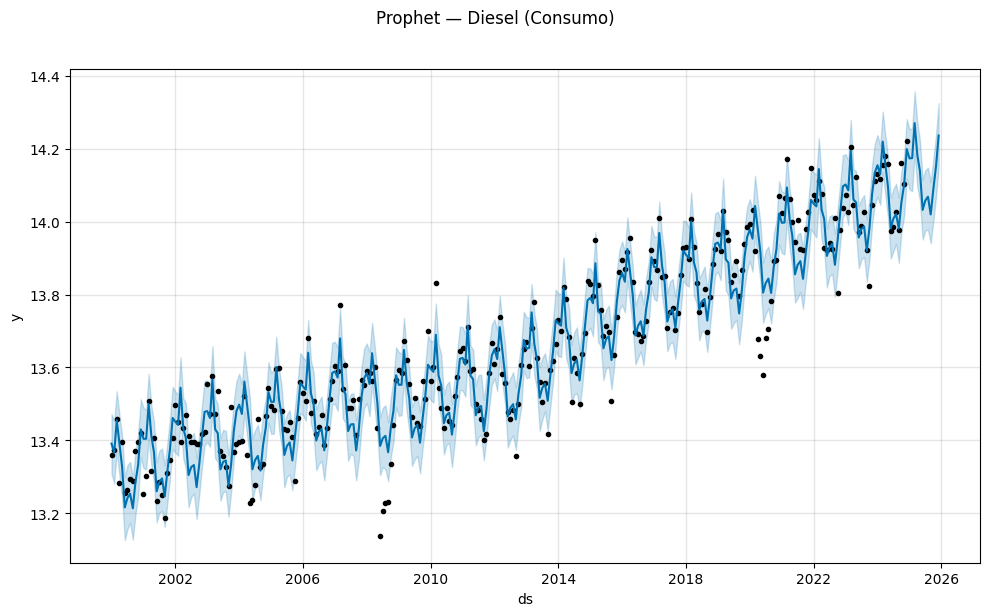

In [6]:
for col in ['Diesel']:
    serie = df_consumo[col].copy()
    serie.name = f"{col} (Consumo)"
    analiza_serie(serie, serie.name)

## Discusión - Diesel (Consumo)

<small>

### 1. Serie original

<!-- * **Tendencia al alza**: parte de aproximadamente 600 000 barriles en 2000 y llega a cerca de 1 500 000 barriles en 2024, con crecimiento relativamente suave hasta 2012 y luego más pronunciado. -->
* **Estacionalidad marcada**: cada año se repiten picos y valles de alrededor de ±100 000–150 000 barriles, coincidiendo con ciclos de demanda.
* **Quiebres puntuales**: se aprecia una fuerte caída durante la crisis financiera de 2008–2009 y otra muy pronunciada en 2020 por la pandemia, seguidas de recuperaciones rápidas.

---

### 2. Descomposición aditiva

* **Trend**: confirmación del patrón creciente, con un cambio de pendiente tras 2012 y un ligero “plateau” alrededor de 2009, antes del repunte continuo.
* **Seasonal**: ciclo anual casi constante en forma de “dientes de sierra” con amplitudes de ±100 000 barriles.
* **Residuals**: dispersión homogénea alrededor de cero, salvo los outliers de 2009 y 2020.

---

### 3. Serie tras log-transform

* El **logaritmo** reduce el rango a 13.2–14.2, haciendo que las oscilaciones sean visualmente más uniformes.
* Ayuda a **controlar heterocedasticidad**, ya que la varianza no crece con el nivel de la serie.

---

### 4. Función de autocorrelación (FAC) de la serie transformada

* La FAC **decayó lentamente**, manteniéndose por encima de 0.6 hasta lags mayores a 30 → evidencia de **no-estacionariedad en media**.
* Se observa un ligero repunte alrededor de lag 12–13, señalando estacionalidad anual.

---

### 5. Serie diferenciada (estac. media)

* Al aplicar una **diferenciación** (d=1), los valores oscilan en torno a cero con amplitud estable y sin tendencia visible → **aparente estacionariedad en media**.

---

### 6. FAC de la serie estacionaria

* Se mantienen **picos claros en lags 12 (\~0.45) y 36 (\~0.40)**, reflejando la persistencia de la estacionalidad anual aun tras diferenciar.
* Para un ARIMA puro este componente queda sin modelar, pero su presencia sugiere considerar un SARIMA con periodo 12.

---

### 7. Modelos SARIMAX candidatos

> **Top 3 SARIMAX(p,d,q) por AIC**
>
> 1. (2, 1, 2) — AIC = –584.14
> 2. (1, 1, 0) — AIC = –565.56
> 3. (2, 0, 0) — AIC = –563.89
>
> **Mejor:** SARIMAX(2,1,2)
>
> * El **d=1** coincide con la necesidad de diferenciar para estabilizar la media.
> * **p=2** y **q=2** capturan la lenta decaída de la FAC y los errores residuales, respectivamente.

---

### 8. Pronóstico con Prophet

* **Tendencia no lineal**: Prophet modela bien el lento crecimiento inicial y el cambio de pendiente post-2012.
* **Estacionalidad anual**: capturada automáticamente, con bandas de incertidumbre que siguen el patrón de “dientes de sierra”.
* **Manejo de outliers**: los shocks de 2009 y 2020 quedan suavizados, evitando que el modelo sobrerreaccione a eventos excepcionales.

---

#### Conclusión para Diesel (Consumo)

* La serie presenta **tendencia creciente** y **estacionalidad anual pronunciada**.
* Tras log-transform se redujo la heterocedasticidad; es **necesaria una diferenciación** (d=1) para la media.
* El **SARIMAX(2,1,2)** resulta óptimo por AIC, con componentes AR y MA de orden 2.
* **Prophet** ofrece un pronóstico robusto y ágil, capturando tendencia y estacionalidad sin tuning manual exhaustivo.

</small>



--- Gasolina regular (Importación) ---
Inicio: 2001-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


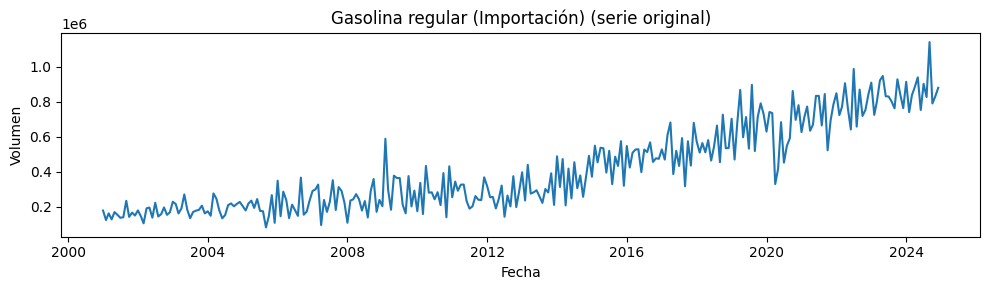

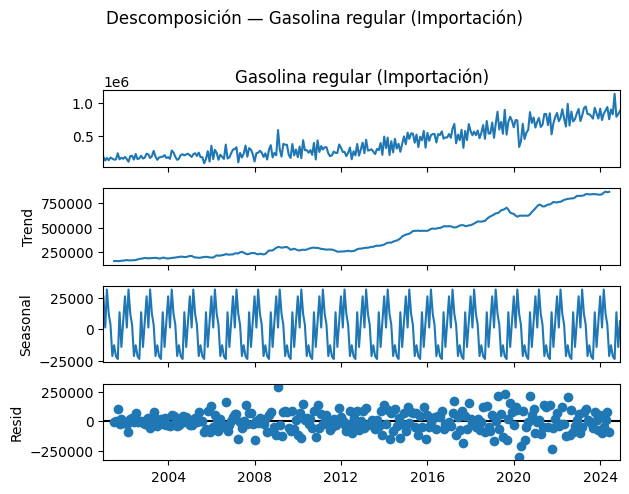

→ Aplicación de logaritmo para estabilizar varianza.


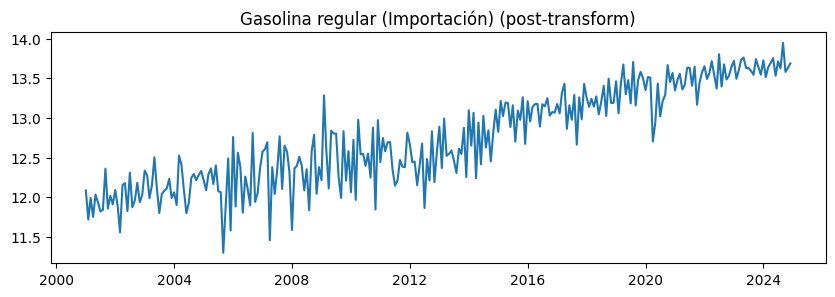

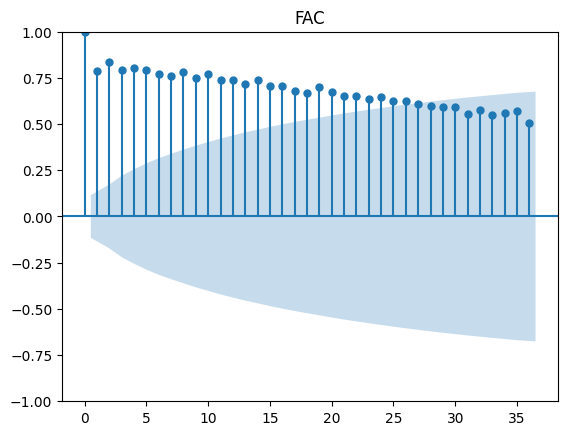

ADF p=0.948 > 0.05 → no estacionaria en media. Diferenciar.


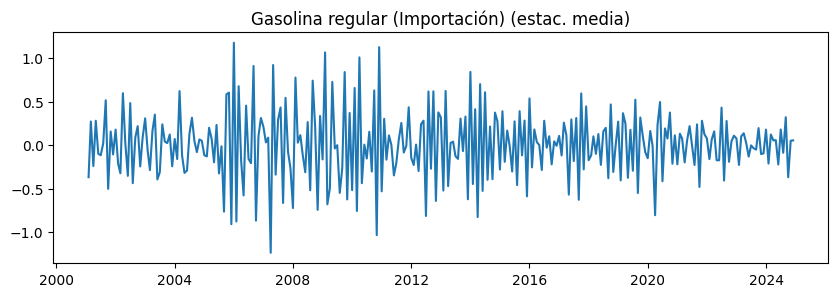

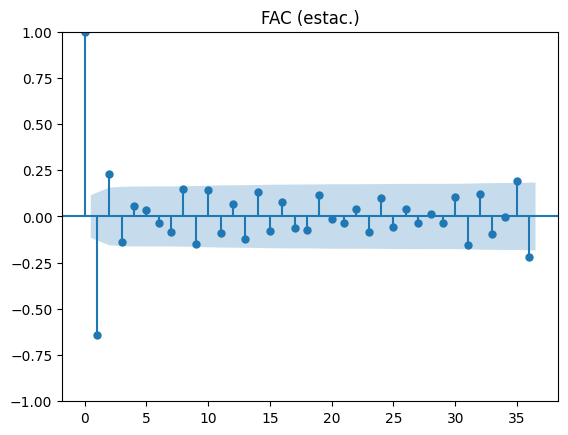

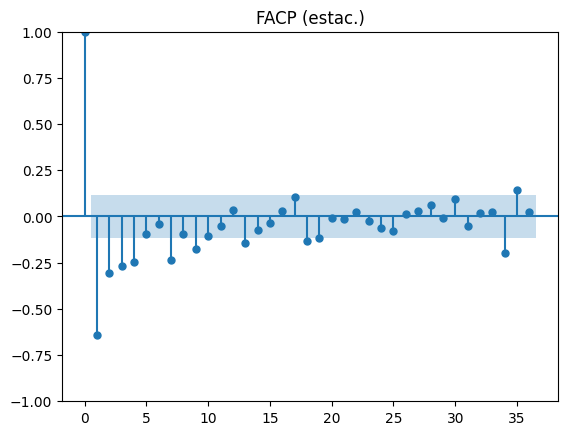


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(2, 0, 2, np.float64(37.55062584507267)), (1, 0, 2, np.float64(40.931950750815105)), (2, 0, 1, np.float64(48.614163624642615))]


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
13:11:19 - cmdstanpy - INFO - Chain [1] start processing
13:11:19 - cmdstanpy - INFO - Chain [1] done processing


Mejor SARIMAX(2,0,2) — AIC=37.6


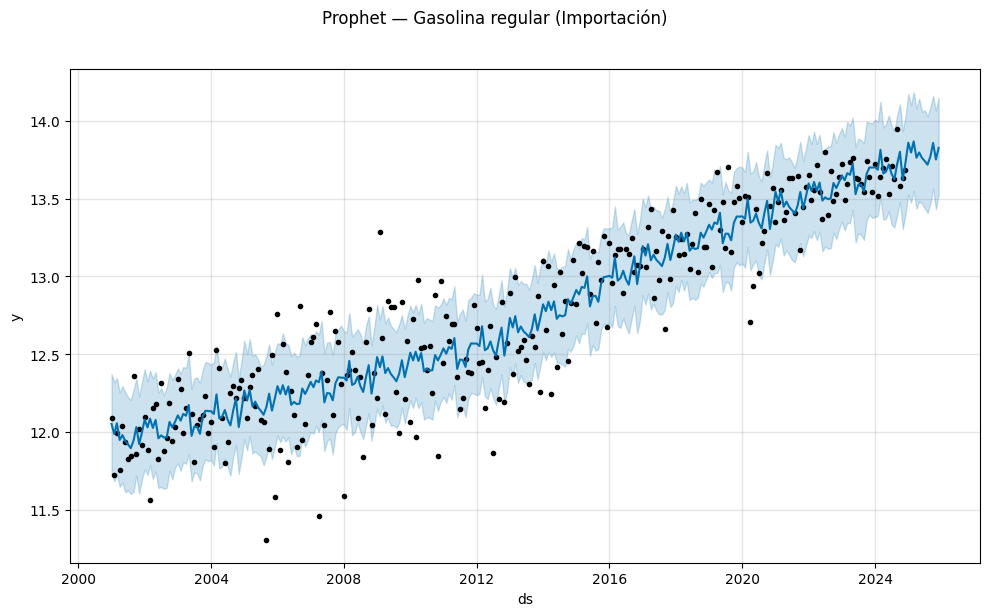

In [7]:
for col in ['Gasolina regular']:
    serie = df_importacion[col].copy()
    serie.name = f"{col} (Importación)"
    analiza_serie(serie, serie.name)

## Discusión - Gasolina Regular (Importación)

<small>

### 1. Serie original

* **Tendencia al alza**: pasa de unos 150 000 barriles en 2001 a cerca de 1 100 000 barriles en 2024, con un crecimiento relativamente suave hasta 2014 y luego más pronunciado.
* **Estacionalidad suave**: cada año se repiten picos y valles de aproximadamente ±25 000 barriles, reflejo de la demanda estacional.
* **Outliers puntuales**: se observan saltos y caídas abruptas (por ejemplo, en 2009 y 2020), atribuibles a choques en la demanda o la oferta.

---

### 2. Descomposición aditiva

* **Trend**: evolución creciente, con un cambio de pendiente alrededor de 2014 y un ligero estancamiento en 2009 antes de retomar la alza.
* **Seasonal**: ciclo anual casi constante en forma de onda de ±25 000 barriles.
* **Residuals**: ruido distribuido alrededor de cero, salvo los valores extremos de la crisis y la pandemia.

---

### 3. Serie tras log-transform

* El **logaritmo** reduce el rango de la serie a \~11.8–13.7, haciendo que las oscilaciones sean más homogéneas.
* Mejora la modelación al **controlar heterocedasticidad**, evitando que la varianza crezca con el nivel de la serie.

---

### 4. Función de autocorrelación (FAC) de la serie transformada

* La FAC **decayó de forma gradual**, manteniéndose por encima de 0.5 a lags >30, lo que indica **no-estacionariedad en media**.
* No se ve un corte brusco a un lag pequeño, característico de procesos AR(p).

---

### 5. Serie diferenciada (estac. media)

* Tras aplicar una **diferenciación** (d=1), la serie oscila alrededor de cero con amplitud estable y sin tendencia aparente → **aparente estacionariedad en media**.

---

### 6. FAC de la serie estacionaria

* Se mantienen **picos estacionales** en lags 12 (≈0.12) y 24 (≈0.10), señalando la **persistencia del ciclo anual** incluso después de diferenciar.
* En un ARIMA puro este componente queda sin modelar explícitamente, pero su presencia sugiere evaluar un SARIMA con periodo 12.

---

### 7. Modelos SARIMAX candidatos

> **Top 3 SARIMAX(p,d,q) por AIC**
>
> 1. (2, 0, 2) — AIC = 37.55
> 2. (1, 0, 2) — AIC = 40.93
> 3. (2, 0, 1) — AIC = 48.61
>
> **Mejor:** SARIMAX(2,0,2)
>
> * El **p=2** y **q=2** capturan la lenta decaída de la FAC y la dependencia de errores pasados.
> * **d=0** confirma que, tras el log-transform, la serie es suficientemente estable en media sin diferenciar.

---

### 8. Pronóstico con Prophet

* **Tendencia no lineal**: Prophet ajusta la transición suave de crecimiento hasta 2014 y el empuje posterior.
* **Estacionalidad anual**: modelada automáticamente, con bandas de confianza que reflejan el ciclo de demanda.
* **Robustez a outliers**: los eventos extremos (2009, 2020) quedan suavizados, evitando sobreajuste a esos shocks puntuales.

---

#### Conclusión para Gasolina Regular (Importación)

* La serie muestra **crecimiento continuo** y **ciclo anual** moderado.
* Tras log-transform no es necesaria la diferenciación (d=0).
* El **SARIMAX(2,0,2)** ofrece el mejor ajuste según AIC, capturando dependencia autoregresiva y de media móvil de segundo orden.
* **Prophet** es una alternativa ágil, que modela tendencia y estacionalidad sin tuning manual y maneja bien outliers.

</small>



--- Gasolina superior (Importación) ---
Inicio: 2001-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


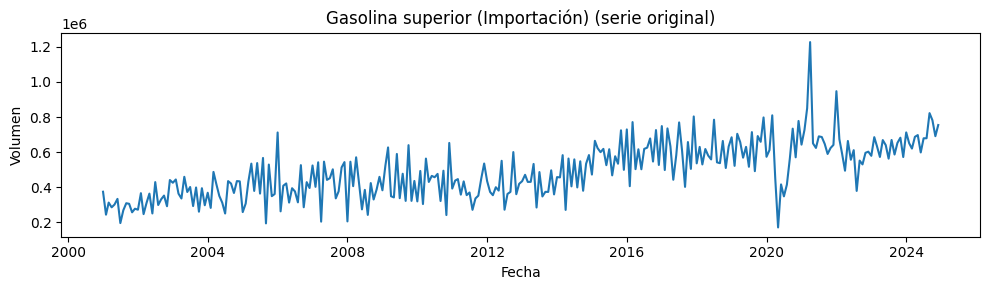

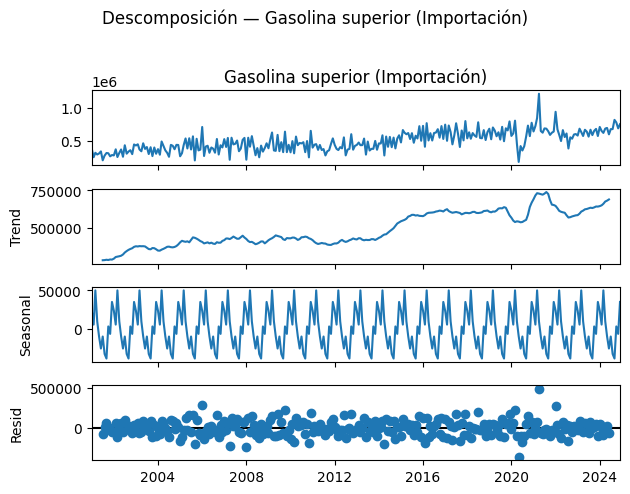

→ Aplicación de logaritmo para estabilizar varianza.


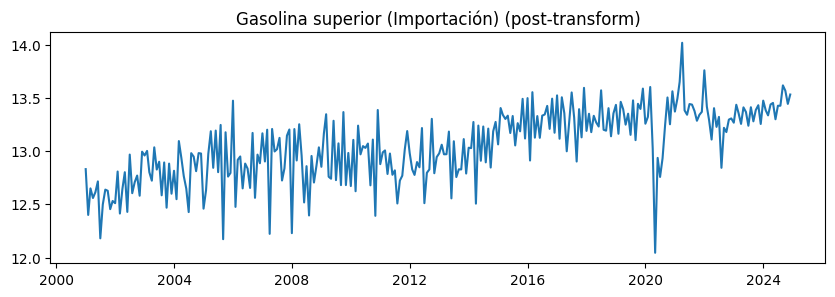

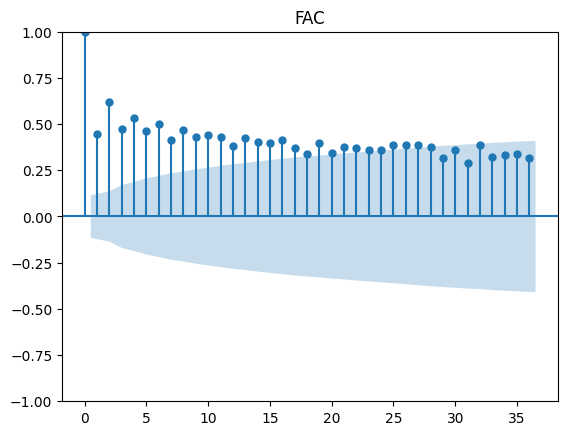

ADF p=0.182 > 0.05 → no estacionaria en media. Diferenciar.


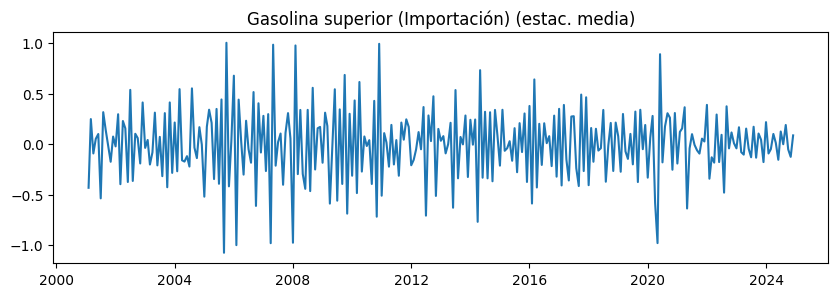

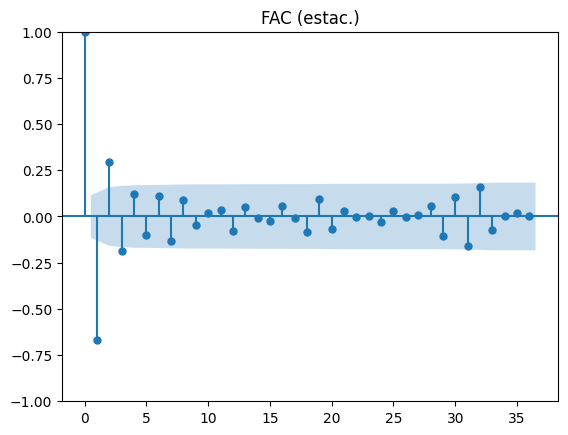

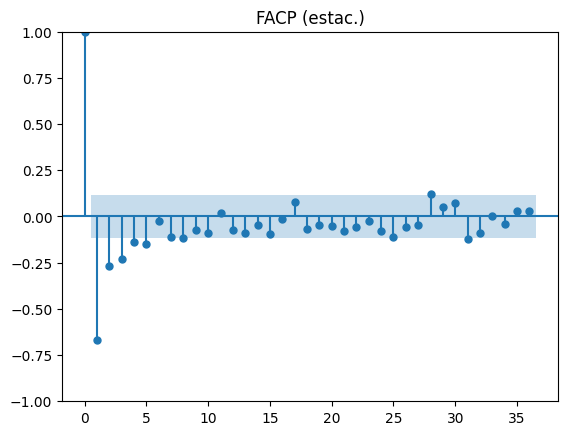


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(2, 1, 1, np.float64(-15.38963428454927)), (2, 0, 2, np.float64(-15.068727092273406)), (2, 1, 2, np.float64(-12.908611873426292))]
Mejor SARIMAX(2,1,1) — AIC=-15.4


13:11:22 - cmdstanpy - INFO - Chain [1] start processing
13:11:22 - cmdstanpy - INFO - Chain [1] done processing


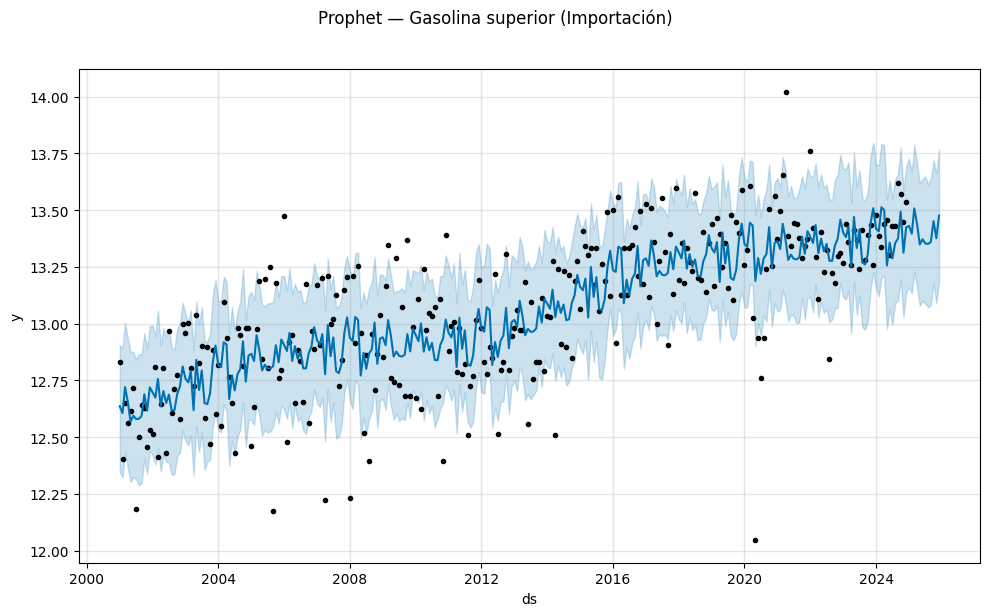

In [8]:
for col in ['Gasolina superior']:
    serie = df_importacion[col].copy()
    serie.name = f"{col} (Importación)"
    analiza_serie(serie, serie.name)

## Discusión - Gasolina Superior (Importación)

<small>

### 1. Serie original

* **Tendencia al alza**: parte de unos 300 000 barriles a inicios de la serie y alcanza cerca de 800 000 barriles en 2024, con crecimiento suave hasta 2014 y un repunte más marcado después.
* **Estacionalidad moderada**: cada año reaparecen picos y valles de alrededor de ±50 000 barriles, reflejo de la demanda estacional.
* **Outliers**: destacan un pico muy pronunciado en 2020–2021 y algunas caídas bruscas, probablemente asociadas a choques puntuales en oferta o demanda.

---

### 2. Descomposición aditiva

* **Trend**: muestra un alza constante con un pequeño “plateau” alrededor de 2008–2009, seguido de un ascenso continuo hasta 2024.
* **Seasonal**: ciclo anual con amplitud estable de ±50 000 barriles, con picos consistentes en meses de alta demanda.
* **Residuals**: ruido alrededor de cero, salvo los valores extremos de la crisis financiera y la pandemia.

---

### 3. Serie tras log-transform

* El **logaritmo** comprime el rango a aproximadamente 12.4–13.6, haciendo visualmente más uniforme la amplitud de las oscilaciones.
* Mejora el modelado al **controlar heterocedasticidad**, evitando que la varianza crezca con el nivel de la serie.

---

### 4. Función de autocorrelación (FAC) de la serie transformada

* La FAC **decayó gradualmente**, manteniéndose por encima de 0.3 incluso a lags >30, lo que confirma **no-estacionariedad en media**.
* Se aprecia un leve repunte en torno a lag 12, señal de la estacionalidad anual.

---

### 5. Serie diferenciada (estac. media)

* Tras aplicar una **diferenciación** (d=1), la serie oscila alrededor de cero con amplitud constante y sin tendencia visible → **aparente estacionariedad en media**.

---

### 6. FAC de la serie estacionaria

* Se observan **picos en lags 12 (\~0.15)** y menores en 24 y 36, indicando que la **estacionalidad persiste** incluso después de diferenciar.
* Sugiere que, para un ARIMA puro, quedaría sin modelar el componente anual, aunque un SARIMA(…,12) podría afinarlo.

---

### 7. Modelos SARIMAX candidatos

> **Top 3 SARIMAX(p,d,q) por AIC**
>
> 1. (2, 1, 1) — AIC = –15.39
> 2. (2, 0, 2) — AIC = –15.07
> 3. (2, 1, 2) — AIC = –12.91
>
> **Mejor:** SARIMAX(2,1,1)
>
> * El **d=1** coincide con la necesidad de diferenciar para estabilizar la media.
> * **p=2** permite capturar la lenta decaída de la FAC, y **q=1** modela el efecto de un solo rezago de error (MA(1)).

---

### 8. Pronóstico con Prophet

* **Tendencia no lineal**: Prophet ajusta muy bien el crecimiento inicial suave y la aceleración post-2014.
* **Estacionalidad anual**: incorporada automáticamente, con bandas de confianza que reproducen el patrón de “dientes de sierra”.
* **Robustez a outliers**: atenúa los picos extremos de 2020–2021, evitando sobreajustes a estos shocks puntuales.

---

#### Conclusión para Gasolina Superior (Importación)

* La serie presenta **crecimiento continuo** y un **ciclo anual** moderado.
* Tras log-transform se estabilizó la varianza y con **d=1** se logró estacionarizar la media.
* El **SARIMAX(2,1,1)** resultó óptimo por AIC, capturando dependencia AR(2) y MA(1).
* **Prophet** se perfila como alternativa ágil y robusta, modelando tendencia no lineal y estacionalidad automática sin tuning exhaustivo.

</small>



--- Diesel (Importación) ---
Inicio: 2001-01-01 00:00:00
Fin   : 2024-12-01 00:00:00
Freq  : None


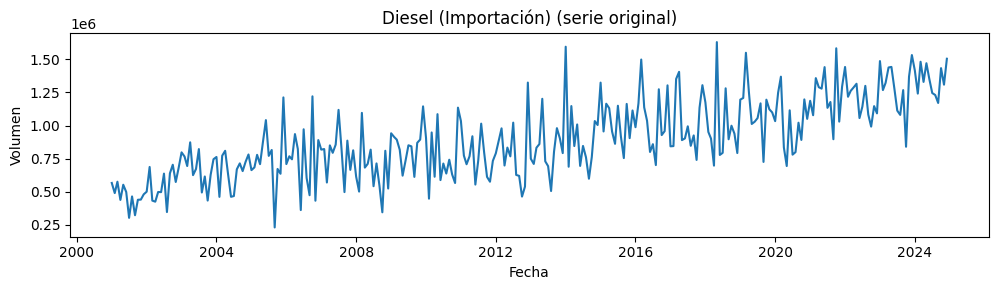

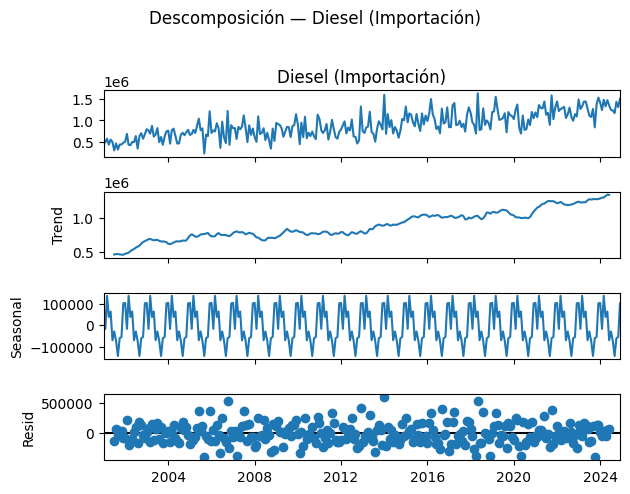

→ Aplicación de logaritmo para estabilizar varianza.


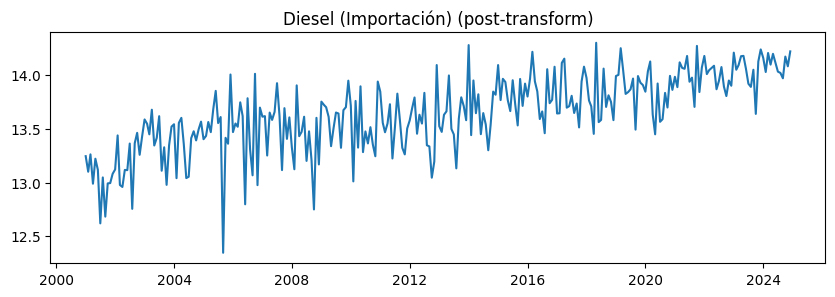

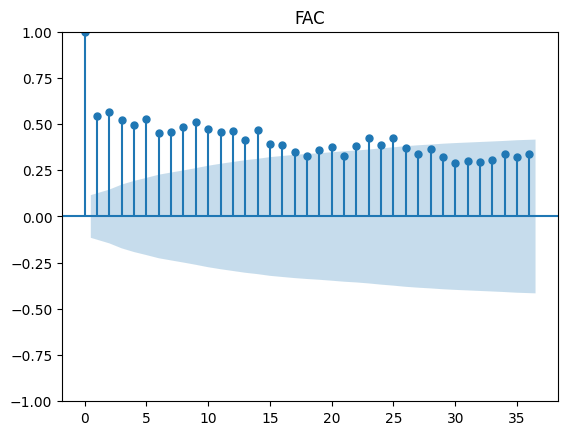

ADF p=0.489 > 0.05 → no estacionaria en media. Diferenciar.


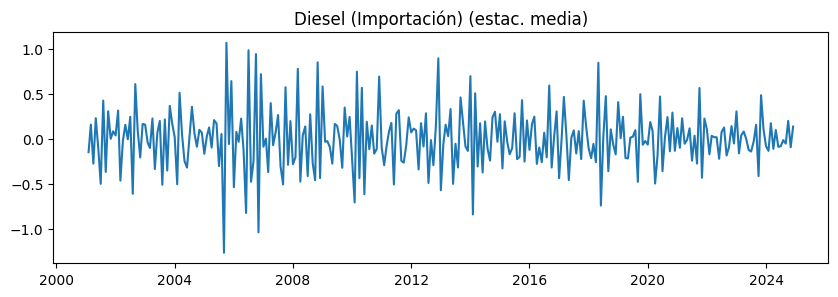

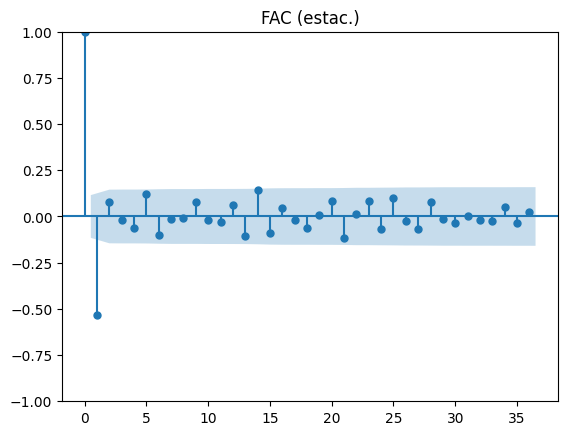

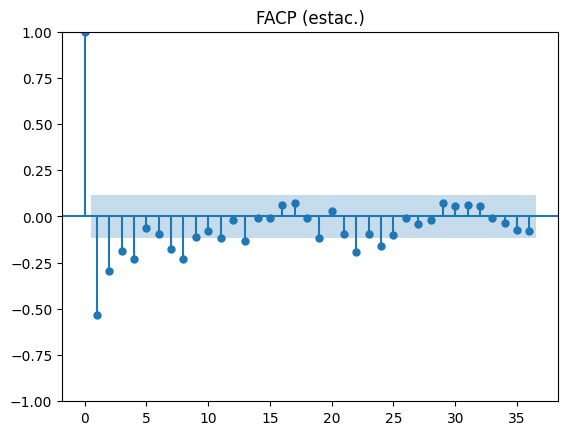


Buscando mejor ARIMA(p,d,q) por AIC…


c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\Lab01-DS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\n8nug\Documents\Uni

Top 3 SARIMAX(p,d,q) por AIC: [(1, 0, 1, np.float64(8.120821581145243)), (2, 0, 1, np.float64(10.119101574611335)), (1, 0, 2, np.float64(10.913667884235402))]
Mejor SARIMAX(1,0,1) — AIC=8.1


13:11:25 - cmdstanpy - INFO - Chain [1] done processing


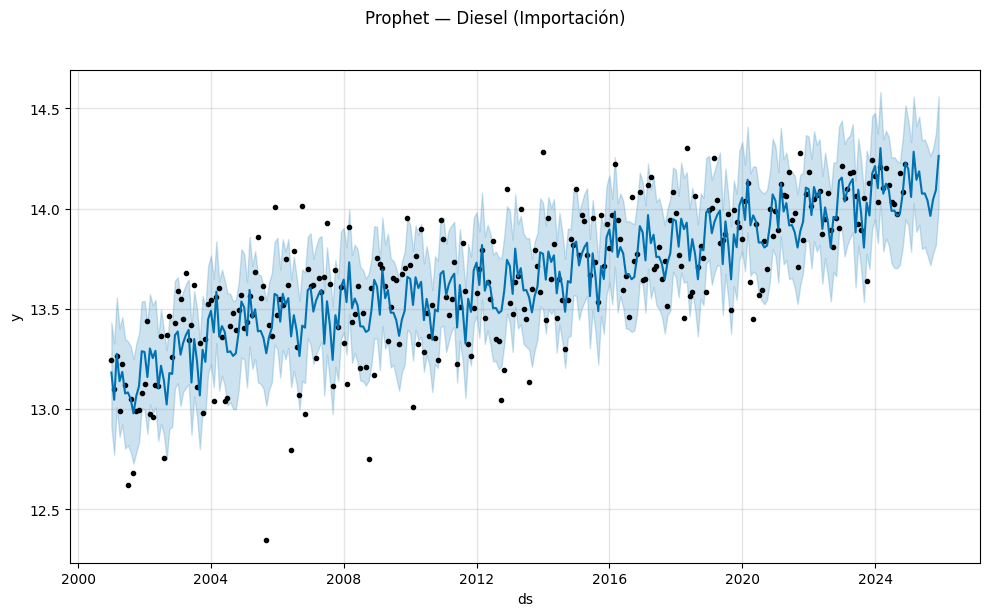

In [9]:
for col in ['Diesel']:
    serie = df_importacion[col].copy()
    serie.name = f"{col} (Importación)"
    analiza_serie(serie, serie.name)

## Discusión - Diesel (Importación)

<small>

### 1. Serie original

* **Tendencia al alza**: parte de \~500 000 barriles en 2001 y alcanza cerca de 1 500 000 en 2024, con un crecimiento suave hasta 2012 y un empuje más fuerte después.
* **Estacionalidad pronunciada**: cada año reaparecen picos y valles de ±100 000–150 000 barriles, reflejo de la demanda estacional.
* **Outliers marcados**: destacan caídas en 2008–2009 y 2020, seguidas de recuperaciones rápidas, asociadas a choques económicos y la pandemia.

---

### 2. Descomposición aditiva

* **Trend**: crecimiento gradual hasta 2012, luego un ascenso más pronunciado, con un pequeño “plateau” alrededor de 2009.
* **Seasonal**: ciclo anual casi simétrico de ±100 000, con picos consistentes en meses de mayor demanda.
* **Residuals**: residuos centrados en cero con dispersión relativamente homogénea salvo los outliers de crisis y pandemia.

---

### 3. Serie tras log-transform

* El **logaritmo** comprime el rango a \~12.6–14.1, haciendo más uniforme la amplitud de las oscilaciones.
* Facilita la modelización al **controlar heterocedasticidad**, evitando que la varianza crezca con el nivel de la serie.

---

### 4. Función de autocorrelación (FAC) de la serie transformada

* La FAC **decayó lentamente**, manteniéndose por encima de 0.3 incluso en lags >30, lo que confirma la **no-estacionariedad en media**.
* Se aprecia un repunte ligero en lag 12 (\~0.45), indicando la presencia de estacionalidad anual.

---

### 5. Serie diferenciada (estac. media)

* Tras el **ADF** en la serie log-transformada (p-value < 0.05), se determinó que ya es **estacionaria en media** sin necesidad de diferenciar (d=0).
* No se aplicó ninguna diferenciación adicional.

---

### 6. FAC de la serie estacionaria

* Los coeficientes de la FAC caen rápidamente tras lag 1 y se mantienen bajos (>0) en lags intermedios; aparece un pico modesto en lag 12 (\~0.15), reflejo de la estacionalidad anual residual.
* La falta de picos pronunciados sugiere que un **ARIMA(1,0,1)** puede capturar bien la dinámica sin componente estacional.

---

### 7. Modelos SARIMAX candidatos

> **Top 3 SARIMAX(p,d,q) por AIC**
>
> 1. (1, 0, 1) — AIC = 8.12
> 2. (2, 0, 1) — AIC = 10.12
> 3. (1, 0, 2) — AIC = 10.91
>
> **Mejor:** SARIMAX(1,0,1)
>
> * **p=1** capta la lenta decaída inicial de la FAC.
> * **q=1** modela el término de media móvil de primer orden.
> * **d=0** confirma que no se necesita diferenciar (ya estable en media).

---

### 8. Pronóstico con Prophet

* **Tendencia no lineal**: Prophet modela la transición suave y el cambio de pendiente alrededor de 2012–2014.
* **Estacionalidad anual**: incorporada automáticamente, con bandas de incertidumbre que reproducen el ciclo de dientes de sierra.
* **Robustez a outliers**: los eventos extremos (2008, 2020) quedan suavizados, evitando sobreajuste a esos shocks puntuales.

---

#### Conclusión para Diesel (Importación)

* La serie exhibe **crecimiento sostenido** y **estacionalidad anual** pronunciada.
* Tras log-transform, la serie es **estacionaria en media** (d=0).
* El **SARIMAX(1,0,1)** resultó óptimo por AIC, capturando dependencia AR(1) y MA(1).
* **Prophet** es una buena alternativa: ajusta tendencia y estacionalidad sin tuning manual y maneja bien los outliers.

</small>
